In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from skimage.feature import hog

#For Multiple Detections & False Positives
from scipy.ndimage.measurements import label
import time
from moviepy.editor import VideoFileClip
#import imageio
#imageio.plugins.ffmpeg.download()


## 1.Changing to an appropriate color space

It helps us more to find the features in an image

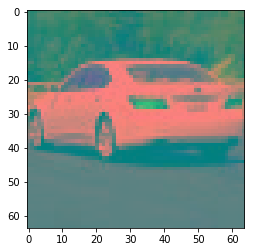

In [2]:
'''
Changing to an appropriate color space
'''
def convert_color(image, color_space='BGR2YCrCb'): #ndarray
    if color_space != 'RGB':
        if color_space == 'HSV':
            image_result = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            image_result = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            image_result = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            image_result = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'BGR2YCrCb':
            image_result = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        elif color_space == 'YCrCb':
            image_result = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        elif color_space == 'GRAY':
            image_result = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        elif color_space == 'RGB2YCrCb':
            image_result = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: image_result = np.copy(image)
    return image_result
'''
This part is only for testing the above function
'''
image = cv2.imread('./all/1200.jpeg')
image = convert_color(image, 'YUV')
plt.imshow(image)
plt.show()

## 2.Resize image

While it could be cumbersome to include three color channels of a full resolution image, you can perform spatial binning on an image and still retain enough information to help in finding vehicles.

As you can see in the example above, even going all the way down to 32 x 32 pixel resolution, the car itself is still clearly identifiable by eye, and this means that the relevant features are still preserved at this resolution.

A convenient function for scaling down the resolution of an image is OpenCV's **cv2.resize()**.

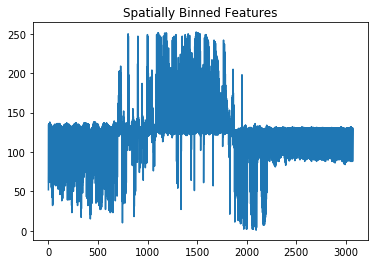

In [3]:
def bin_spatialI(img, size=(32, 32)):
    small_img = cv2.resize(img, (32, 32))
    #to convert this to a one dimensional feature vector
    feature_vec = small_img.ravel()
    return feature_vec

'''
This part is only for testing the above function
'''
#image = mpimg.imread('./all/1200.jpeg')
image = cv2.imread('./all/1200.jpeg')
feature_vec = bin_spatialI(convert_color(image, 'YCrCb'), size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')
plt.show()

## 3.Generate the color histogram

With **np.histogram()**, you don't actually have to specify the number of bins or the range, but here I've arbitrarily chosen 32 bins and specified **range=(0, 256)** in order to get orderly bin sizes. **np.histogram()** returns a tuple of two arrays. 

In this case, for example, **rhist[0]** contains the counts in each of the bins and **rhist[1]** contains the bin edges (so it is one element longer than **rhist[0]**).

These, collectively, are now our feature vector for this particular cutout image. We can concatenate them in the following way:

**hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))**

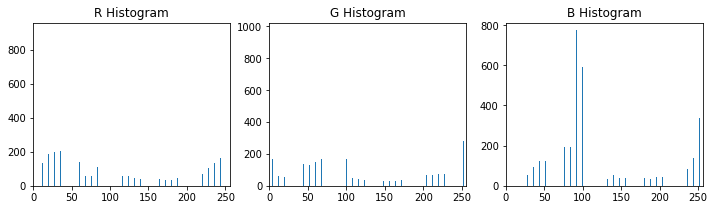

In [4]:
'''
Generate the color histogram 
'''
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins , range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins , range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins , range=bins_range)
    
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], 
                                    channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return channel1_hist,channel2_hist,channel3_hist,hist_features

'''
This part is only for testing the above function
'''
image = cv2.imread('./all/1200.jpeg')
channel1, channel2, channel3 , hist_features = color_hist(image)

# Generating bin centers
bin_edges = channel1[1]
bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

# Plot a figure with all three bar charts
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, channel1[0])
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(132)
plt.bar(bin_centers, channel2[0])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(133)
plt.bar(bin_centers, channel3[0])
plt.xlim(0, 256)
plt.title('B Histogram')
plt.show()

## 4.Extracting the Histogram of Oriented Gradient (scikit-image HOG)


The scikit-image **hog()** function takes in a single color channel or grayscaled image as input, as well as various parameters. These parameters include **orientations**, **pixels_per_cell** and **cells_per_block**.

The number of **orientations** is specified as an integer, and represents the number of orientation bins that the gradient information will be split up into in the histogram. Typical values are between 6 and 12 bins.

The **pixels_per_cell** parameter specifies the cell size over which each gradient histogram is computed. This paramater is passed as a 2-tuple so you could have different cell sizes in x and y, but cells are commonly chosen to be square.

The **cells_per_block** parameter is also passed as a 2-tuple, and specifies the local area over which the histogram counts in a given cell will be normalized. Block normalization is not necessarily required, but generally leads to a more robust feature set.

There is another optional power law or "gamma" normalization scheme set by the flag **transform_sqrt**. This type of normalization may help reduce the effects of shadows or other illumination variation, but will cause an error if your image contains negative values (because it's taking the square root of image values).

The **visualise=True** flag tells the function to output a visualization of the HOG feature computation as well, which we're calling **hog_image** in this case.

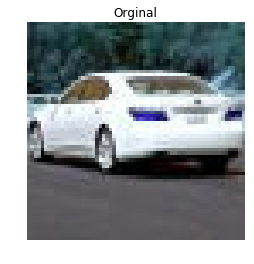

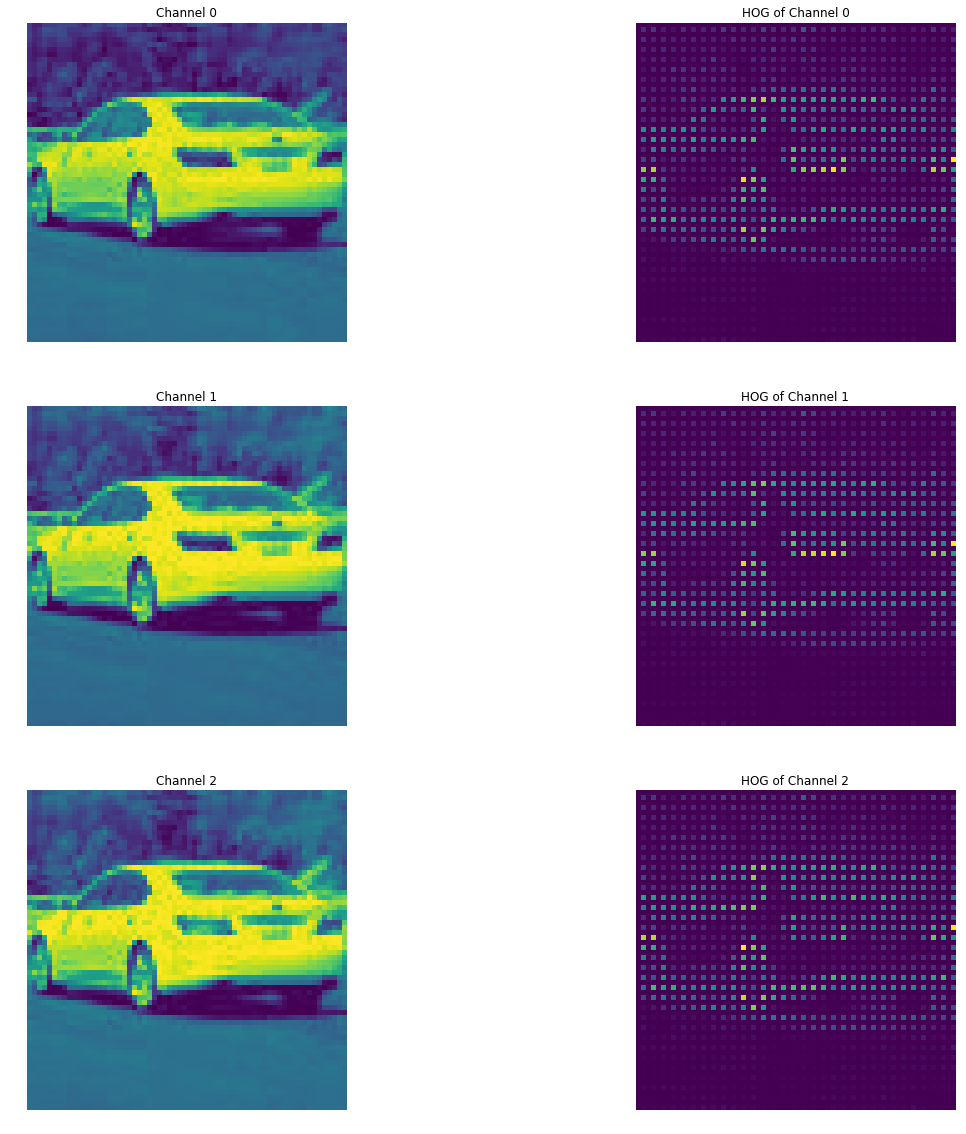

In [5]:
'''
Extracting the Histogram of Oriented Gradient
'''
def get_hog_features(myimg, orient, pix_per_cell, 
                     cell_per_block,vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(myimg, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell,pix_per_cell),
                                  cells_per_block=(cell_per_block,cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(myimg, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
'''
This part is only for testing the above function
'''
image = cv2.imread('./all/1200.jpeg')
plt.imshow(image )
plt.title('Orginal')
plt.axis('off')
plt.show()

plt.figure(figsize=(20, 20))
subplotcounter = 1
for channel in range(image.shape[2]):
    
    plt.subplot(3, 2, subplotcounter)
    plt.imshow(image[:,:,channel] )
    plt.title('Channel {}'.format(channel))
    plt.axis('off')
    subplotcounter = subplotcounter + 1

    plt.subplot(3, 2,subplotcounter )
    f,g = get_hog_features(image[:,:,channel], 9, 2,2,vis=True, feature_vec=True)
    plt.imshow(g )
    plt.title('HOG of Channel {}'.format(channel))
    plt.axis('off')
    subplotcounter = subplotcounter + 1

plt.show() 

## 6.Global values

### 6.1. Tuning the SVM Hyperparameters
The gamma value and the C value that minimize prediction error. To tune the SVM vehicle detection model, we can use one of scikit-learn's parameter tuning algorithms.

When tuning SVM, we can only tune the C parameter with a linear kernel. For a non-linear kernel, we can tune C and gamma.

In [6]:
c_value = 0.0001


In [7]:
X_scaler = 0

color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb


spatial_size = (64,64) # Spatial binning dimensions
spatial_feat = False # Spatial features on or off

#------------------------------------
# Color Histogran Classify
#------------------------------------
hist_bins = 64    # Number of histogram bins
hist_feat = True # Histogram features on or off

#------------------------------------
# HOG Classify
#------------------------------------
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
hog_feat = True # HOG features on or off



## 5.Combine and Normalize Features

- Bin spatial
- Color histogram

Now we'll try training a classifier on our dataset. First, we'll see how well it does just using spatially binned color and color histograms.

Count of vehicles 8792 , Count of non-vehicles 8968
Shape Spatioal with shape (3072,)
Shape His with shape (96,)
Shape Hog with shape (972,)
Shape Spatioal with shape (3072,)
Shape His with shape (96,)
Shape Hog with shape (972,)


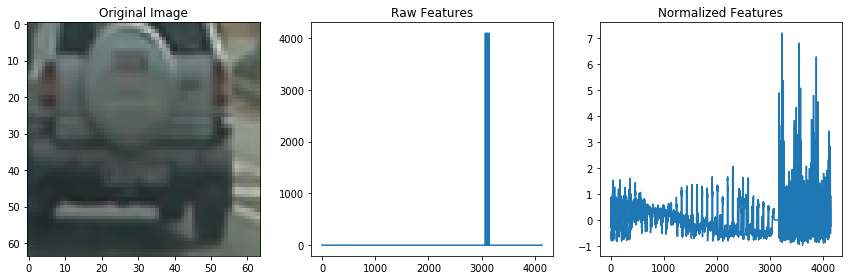

In [22]:
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    
    showshape=1
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)  
            
        # Compute individual channel HOG features for the entire image
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append( get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, 
                                                  cell_per_block, feature_vec=False))
        hog_features = np.ravel(hog_features)   
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatialI(feature_image, size=spatial_size)
        
        # Apply color_hist() also with a color space option now
        a,b,c,hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        
        if showshape == 1:
            print('Shape {} with shape {}'.format('Spatioal',spatial_features.shape ))
            print('Shape {} with shape {}'.format('His',hist_features.shape ))
            print('Shape {} with shape {}'.format('Hog',hog_features.shape ))
            showshape = 0
        
        
    # Return list of feature vectors
    return features
'''
This part is only for testing the above function
'''
images = glob.iglob('./all/vehicles/**/*.png',recursive=True)
cars = []
notcars = []
for image in images:
    cars.append(image)
images = glob.glob('./all/non-vehicles/**/*.png',recursive=True)
for image in images:
    notcars.append(image)    
print('Count of vehicles {} , Count of non-vehicles {}'.format(len(cars) , len(notcars)))

car_features = extract_features(cars, cspace='RGB', 
                                spatial_size=(32, 32),
                                hist_bins=32, 
                                hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', 
                                   spatial_size=(32, 32),
                                   hist_bins=32, 
                                   hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    plt.show()
else: 
    print('Your function only returns empty feature vectors...')

## 7.Load Training/Test Dataset

In [9]:
images = glob.iglob('./all/vehicles/**/*.png',recursive=True)
cars = []
notcars = []
for image in images:
    cars.append(image)
images = glob.glob('./all/non-vehicles/**/*.png',recursive=True)
for image in images:
    notcars.append(image)    
print('Count of vehicles {} , Count of non-vehicles {}'.format(len(cars) , len(notcars)))

Count of vehicles 8792 , Count of non-vehicles 8968


## 8.Train Linear SVC linear SVC (support vector classifier) Classifier

The input for training model and predicting should have same size.

In [10]:
'''
The input for training model and predicting should have same size.
'''
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32,32)
hist_bins = 32
color_space = 'RGB'
hist_range = (0, 256)

In [11]:

#------------------------------------
# HOG Classify
#------------------------------------
t=time.time()
'''
Extract HOG, Spatial and Histogram features

car_features = extract_featuresII(cars, color_space=color_space, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_size=spatial_size, hist_bins=hist_bins ,
                                spatial_feat = spatial_feat, hist_feat = hist_feat, 
                                hog_feat = hog_feat)
notcar_features = extract_featuresII(notcars, color_space=color_space, orient=orient, 
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_size=spatial_size, hist_bins=hist_bins ,
                                    spatial_feat = spatial_feat, hist_feat = hist_feat, 
                                    hog_feat = hog_feat)
'''

'''
Prepare dataset
'''
car_features = extract_features(cars, cspace = color_space, 
                                spatial_size = spatial_size,
                                hist_bins = hist_bins, 
                                hist_range = hist_range)
notcar_features = extract_features(notcars, cspace = color_space, 
                                   spatial_size = spatial_size,
                                   hist_bins = hist_bins, 
                                   hist_range = hist_range)


if len(car_features) > 0 and len(notcar_features) > 0:
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG, Spatial and Histogram features.')
    
    '''
    Define the labels vector
    '''
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    '''
    Create an array stack of feature vectors
    '''
    X = np.vstack((car_features, notcar_features)).astype(np.float64)           
    
    '''
    Split up data into randomized training and test sets.
    This performs both the shuffle and split of the data and you'll 
    call it like this.
    '''
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.3, 
                                                        random_state=rand_state)

    '''
    Fit a per-column scaler
    Now that we have split into training and test sets, 
    we can scale our features. It's important to do the 
    scaling after splitting the data, otherwise you are 
    allowing the scaler to peer into your test data!
    '''
    X_scaler = StandardScaler().fit(X_train)
    
    '''
    Apply the scaler to both X_train and X_test
    ''' 
    scaled_X_train = X_scaler.transform(X_train)
    scaled_X_test = X_scaler.transform(X_test)
    
   
    #------------------------------------
    # Color Classify Training & HOG Classify
    #------------------------------------
    print('Using spatial binning of:',spatial_size,'and', hist_bins,'histogram bins')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC(C = c_value)
    # Check the training time for the SVC
    t=time.time()
    svc.fit(scaled_X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', svc.score(scaled_X_test, y_test))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(scaled_X_test[0:10]))
    print('For labels: ', y_test[0:10])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')    
    
else: 
    print('Function returns empty feature vectors because the car and non-car images are empty.')


70.21 Seconds to extract HOG, Spatial and Histogram features.
Using spatial binning of: (32, 32) and 32 histogram bins
Feature vector length: 8460
4.37 Seconds to train SVC...
Test Accuracy of SVC =  0.976539039039039
My SVC predicts:  [0. 1. 0. 1. 0. 0. 1. 0. 1. 1.]
For labels:  [0. 1. 0. 1. 0. 0. 1. 0. 1. 1.]
0.00399 Seconds to predict 10 labels with SVC


**This the result of testing the trained model with color histogram and spetial bin.**

102.83 Seconds to extract HOG, Spatial and Histogram features.

Using spatial binning of: (64, 64) and 64 histogram bins

Feature vector length: 3168

4.91 Seconds to train SVC...

Test Accuracy of SVC =  0.9194819819819819

My SVC predicts:  [0. 0. 0. 1. 0. 0. 1. 1. 1. 0.]

For labels:  [0. 0. 0. 1. 0. 1. 1. 1. 0. 0.]

0.00599 Seconds to predict 10 labels with SVC


In [12]:
import random

In [13]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    imcopy = np.copy(img)
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    print(x_start_stop)
    print(y_start_stop)
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    print('xspan {} , yspan {} '.format(xspan,yspan))
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    
    '''
    First 4 rows for first scale
    '''
    
    
    
    for ys in range(ny_windows):
        rowcolor = [random.randint(0,255),random.randint(0,255),random.randint(0,255)]
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(imcopy, (startx, starty), (endx, endy), rowcolor, 1)            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
        #break
    # Return the list of windows
    plt.imshow(imcopy)
    plt.show()
    cv2.imwrite('./test_images/imcopy.jpg',imcopy)
    return window_list

[200, 1290]
[400, 670]
xspan 1090 , yspan 270 


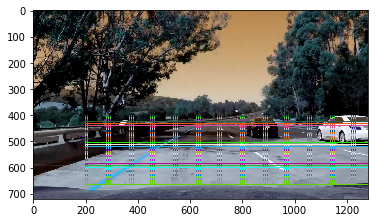

In [14]:
y_start_stop = [400, 670]
image = cv2.imread('./test_images/test5.jpg')
windows = slide_window(image, x_start_stop=[200, 1290], y_start_stop=y_start_stop, 
                    xy_window=(16, 16), xy_overlap=(0.5, 0.5))

In [15]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
              hist_bins, color_space, hist_range):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space = color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatialI(subimg, size=spatial_size)
            a,b,c,hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)

            
            # Scale features and make a prediction
            
            
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features)).reshape(1, -1))    
            test_features = X_scaler.transform(np.concatenate((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
            #features.append(np.concatenate((spatial_features, hist_features, hog_features)))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, bboxes

## Drawing boxes in an image

In [16]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## Multiple Detections & False Positives
**Solution is Heat-Map**
<br>
To make a heat-map, you're simply going to add "heat" (+=1) for all pixels within windows where a positive detection is reported by your classifier.
<br>
If the classifier is working well, then the "hot" parts of the map are where the cars are, and by imposing a threshold, you can reject areas affected by false positives therefore we use the *apply_threshold* function.

In [17]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

I integrate a heat map over images, such that areas of multiple detections get "hot", while transient false positives stay "cool". I can then simply threshold the heatmap to remove false positives with this line.
```ruby
heatmap[heatmap <= threshold] = 0
```
<br>
once heat-map is thresholded, there are many ways to figure out how many cars we have in each frame and which pixels belong to which cars, but one of the most straightforward solutions is to use the *label()* function from *scipy.ndimage.measurements*.

In [18]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [19]:
def draw_labeled_bboxes(img, labels):
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (10,500)
    fontScale              = 1
    fontColor              = (0,0,255)
    lineType               = 2    
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bottomLeftCornerOfText = (np.min(nonzerox), np.min(nonzeroy))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        cv2.putText(img,'Car{}'.format(car_number), 
                    bottomLeftCornerOfText, 
                    font, 
                    fontScale,
                    fontColor,
                    lineType)
    # Return the image
    return img

In [20]:
ystart = 400
ystop = 656
scale = 2
heat_threshold = 0
percentage_fraction = 5

orient = 9
pix_per_cell = 16
cell_per_block = 2
spatial_size = (32,32)
hist_bins = 32
color_space = 'RGB'
hist_range = (0, 256)


img = cv2.imread('./test_images/test5.jpg')    
out_img, out_boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                    spatial_size, hist_bins, color_space , hist_range)

out_img = draw_boxes(img, out_boxes, (0, 255, 155), 2)

heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,out_boxes)
        
# Apply threshold to help remove false positives
heat_threshold = (max( heat.max(axis=0)) * percentage_fraction)/100 
if heat_threshold < 1 : 
    heat_threshold = 1
heat = apply_threshold(heat,1)
        
       
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)        
            
# Find final boxes from heatmap using label function
labels = label(heatmap)


out_img = draw_labeled_bboxes(np.copy(image), labels)


plt.imshow(out_img)
plt.show()

ValueError: operands could not be broadcast together with shapes (1,4140) (8460,) (1,4140) 

In [ ]:
ystart = 400
ystop = 656
scale = 1.5
heat_threshold = 0
percentage_fraction = 5

img = cv2.imread('./test_images/test5.jpg')    
out_img, out_boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                    spatial_size, hist_bins, color_space , hist_range)
out_img = draw_boxes(img, out_boxes, (0, 255, 155), 2)

heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,out_boxes)
        
# Apply threshold to help remove false positives
heat_threshold = (max( heat.max(axis=0)) * percentage_fraction)/100 
if heat_threshold < 1 : 
    heat_threshold = 1
heat = apply_threshold(heat,1)
        
       
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)        
            
# Find final boxes from heatmap using label function
labels = label(heatmap)


out_img = draw_labeled_bboxes(np.copy(image), labels)


plt.imshow(out_img)
plt.show()

In [ ]:
ystart = 400
ystop = 656
scale = 1
heat_threshold = 0
percentage_fraction = 5

img = cv2.imread('./test_images/test5.jpg')    
out_img, out_boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                    spatial_size, hist_bins, color_space , hist_range)
out_img = draw_boxes(img, out_boxes, (0, 255, 155), 2)

heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,out_boxes)
        
# Apply threshold to help remove false positives
heat_threshold = (max( heat.max(axis=0)) * percentage_fraction)/100 
if heat_threshold < 1 : 
    heat_threshold = 1
heat = apply_threshold(heat,1)
        
       
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)        
            
# Find final boxes from heatmap using label function
labels = label(heatmap)


out_img = draw_labeled_bboxes(np.copy(image), labels)


plt.imshow(out_img)
plt.show()

In [ ]:
ystart = 400
ystop = 656
scale = 0.75
heat_threshold = 0
percentage_fraction = 5

img = cv2.imread('./test_images/test5.jpg')    
out_img, out_boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                    spatial_size, hist_bins, color_space , hist_range)
out_img = draw_boxes(img, out_boxes, (0, 255, 155), 2)

heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,out_boxes)
        
# Apply threshold to help remove false positives
heat_threshold = (max( heat.max(axis=0)) * percentage_fraction)/100 
if heat_threshold < 1 : 
    heat_threshold = 1
heat = apply_threshold(heat,1)
        
       
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)        
            
# Find final boxes from heatmap using label function
labels = label(heatmap)


out_img = draw_labeled_bboxes(np.copy(image), labels)


plt.imshow(out_img)
plt.show()

## Finding boxes as the position of vehicle
This function is the adapted version of tutorial 
<br>
Output: is the boxes which would be the position of vehicles.

In [ ]:
def find_carsII(img, 
                orient, pix_per_cell, cell_per_block, 
                spatial_size, hist_bins, color_space ,
                x_start_stop=[None, None],  
                y_start_stop=[None, None], 
                xy_window=(64, 64), xy_overlap=(0.5, 0.5),
                hog_channel = True,
                spatial_feat=True , hist_feat = True , hog_feat = True ):

    '''
    If x and/or y start/stop positions not defined, set to image size or set to Zero.
    '''
    if  x_start_stop[0]==None:
        x_start_stop = (0, x_start_stop[1])
    if  x_start_stop[1]==None:
        x_start_stop = (x_start_stop[0], img.shape[1])
    if  y_start_stop[0]==None:
        y_start_stop = (0, y_start_stop[1])
    if  y_start_stop[1]==None:
        y_start_stop = (y_start_stop[0], img.shape[0])

    #print('x values {}'.format(x_start_stop))
    #print('y values {}'.format(y_start_stop))
    
    ypos = y_start_stop[0]    
    draw_img = np.copy(img)

    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))

    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 

    
    # apply color conversion if other than 'RGB'
    draw_img = convert_color(draw_img, color_space=color_space)
 
    ch1 = img[:,:,0]
    ch2 = img[:,:,1]
    ch3 = img[:,:,2]
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    allfeatures = []
    # Initialize a list to append validate positions of boxes
    bboxes = []

    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            #window_list.append(((startx, starty), (endx, endy)))
    
            #print('starty {}:endy {}, startx{}:endx{}'.format(starty,endy, startx,endx))
            # Extract the image patch
            subimg = cv2.resize(draw_img[starty:endy, startx:endx,:], (64,64))
   
            # Get color features
            if spatial_feat == True : 
                spatial_features = bin_spatial(subimg, size=spatial_size)
                #print('spatial_features'.format(spatial_features.shape))
                allfeatures.append(spatial_features)
    
            if hist_feat == True:
                hist_features = color_hist(subimg, nbins=hist_bins)
                #print('hist_features {}'.format(hist_features.shape))
                allfeatures.append(hist_features)

            # Extract HOG for this patch
            if hog_feat == True :
                if hog_channel == 'ALL':
                    hog_features = []
                    #for channel in range(subimg.shape[2]):
                    #    hog_features.append(get_hog_features(subimg[:,:,channel],orient, 
                    #                                         pix_per_cell, 
                    #                                         cell_per_block, 
                    #                                         vis=False, feature_vec=False))
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    
                    hog_features = np.ravel(hog_features)  
                    #print('hog_features{}'.format(hog_features.shape))
                else:
                    hog_features = get_hog_features(subimg[:,:,hog_channel], orient, 
                                                    pix_per_cell, 
                                                    cell_per_block, 
                                                    vis=False, feature_vec=False)
                allfeatures.append(hog_features)
                
            # Scale features and make a prediction
            if len(allfeatures) == 1:
                test_features = X_scaler.transform(allfeatures[0].reshape(-1, 1))    
            elif len(allfeatures) > 1 :
                a=np.concatenate(allfeatures)
                #print('a{}'.format(a.shape))
                test_features = X_scaler.transform(np.concatenate(allfeatures).reshape(1, -1))    
                
            allfeatures.clear()
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                bboxes.append(((startx, starty), (endx, endy)))
           
    return bboxes

In [ ]:
impath = './test_images/test1.jpg'
image = cv2.imread(impath)
draw_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                     spatial_size, hist_bins, color_space , hist_range)
plt.imshow(draw_img)
plt.show()

##### visualizing the search area

In [ ]:
def visualiz_search_area(image, x_left, x_right, y_top, y_bottom ):
    '''
    p2              p3
    
    
    
    p1             p4
    '''
    image = np.copy(image)
    p1 = (x_left , y_bottom)
    p2 = (x_left , y_top)
    p3 = (x_right , y_top)
    p4 = (x_right , y_bottom)

    #  1     2
    #
    #  4     3
    #
    color = [255, 0, 0]
    w = 2
    cv2.line(image, p1 , p2 , color, w)
    cv2.line(image, p2 , p3 , color, w)
    cv2.line(image, p3 , p4 , color, w)
    cv2.line(image, p4 , p1 , color, w)
    return image

for impath in glob.glob('./test_images/test*.jpg'):
    #image = mpimg.imread(impath)
    image = cv2.imread(impath)
    image = visualiz_search_area(image, 600, image.shape[1],400, 656 )  
    plt.imshow(image)
    plt.show()    


## Using LinearSVC Classifier to detect vehicles in an Image via defined function

In [ ]:
def process_each_image(image):
    
    #------------------------------------
    # Hog Sub-sampling Window Search
    #------------------------------------
    ystart = 400
    ystop = 656
    xstart = 600
    overlap = 0.80
    
    #------------------------------------------------------
    # This line is for Multiple Detections & False Positives
    #------------------------------------------------------
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    win_size = 64
    scale = 0.75
    heat_threshold = 0
    percentage_fraction = 5
    while (scale <= 2):
            
        #box_list = find_cars(np.copy(image), ystart, ystop, scale, svc, X_scaler, 
        #                    orient, pix_per_cell, cell_per_block, 
        #                    spatial_size, hist_bins, color_space,
        #                    spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)

        box_list = find_carsII(np.copy(image), 
                                x_start_stop=(xstart, None), y_start_stop=(ystart, ystop),
                                xy_window=(int(win_size/scale), int(win_size/scale)), xy_overlap=(overlap, overlap),
                                orient = orient, pix_per_cell = pix_per_cell, cell_per_block=cell_per_block, 
                                spatial_size = spatial_size, hist_bins = hist_bins, color_space = color_space,
                                hog_channel = hog_channel,
                                spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)
        
        
        # Add heat to each box in box list
        heat = add_heat(heat,box_list)  

        
        scale = scale + 0.25
        box_list.clear()

        
    # Apply threshold to help remove false positives
    heat_threshold = (max( heat.max(axis=0)) * percentage_fraction)/100 
    if heat_threshold < 1 : 
        heat_threshold = 1
    heat = apply_threshold(heat,1)
        
       
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)        
            
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    # Variables of Multiple Detections & False Positives
    # Now labels is a 2-tuple, where the first item is an array the size of the 
    # heatmap input image and the second element is the number of labels (cars) 
    # found.            
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

In [ ]:
if len(car_features) > 0:
    t=time.time()
    #for impath in glob.glob('./test_images/test*.jpg'):
        #image = mpimg.imread(impath)
    impath = './test_images/test1.jpg'
    image = cv2.imread(impath)
    draw_img = process_each_image (image)
    showImage(draw_img , '{}'.format(impath)) 
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds for processing an image.')

else: 
    print('Your function only returns empty feature vectors...')
plt.show()

In [ ]:
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_each_image)
%time clip_test_out.write_videofile(test_out_file, audio=False)